# Install libraries

In [ ]:
#install XGBoost
!pip install xgboost

In [ ]:
#required libraries
import numpy as np
import math

In [ ]:
#installing surrogate modelling toolbox
!pip install smt

# Bounds (functions- 3,5,9,12,14,17)


In [ ]:
#f3
 i=1,2,3,4, lb=0; ub=4; b=[8, 18, 44, 114];

#f5
 i=1,2,3 lb=0; ub=1; a=[1.0, 1.2, 3.0, 3.2]; A=[[3.0,10,30],[0.1,10,35],[3.0,10,30],[0.1,10,35]] 
 P=[[0.3689,0.1170,0.2673], [0.4699, 0.4387, 0.7470], [0.1091, 0.8732, 0.5547],[0.0381, 0.5743,0.8828]]

#f9
rw= lb=0.05 ub= 0.15, r= lb=100; ub=50000,
Tu= lb=63070; ub=115600, Hu= lb=990; ub=1110,
Tl= ub=63.1; ub=116, Hl=lb=700; ub= 820,
L= lb=1120; ub=1680 and Kw= lb=9855; ub=12045;

#f12
L= lb=0; ub=1, theta= lb=0; ub=2*pi, j = 1; 2; 3; 4

#f14
x= lb=0; ub=5; i = 1... 16
from numpy import array
from scipy.sparse import csr_matrix
 for i in range(0,17):
   A[i][i]=1;

   
#f17
x= lb=-10; ub=10; i = 1... 14


# TEST FUNCTIONS
> Generation of small and large DoE points and test points; Making Metamodels; Calculation of NRMSE values




# FUNCTION 3



In [ ]:
 #required libraries
!pip install smt
import numpy as np
import math

# Function 3
def f3(x):
  b=[8, 18, 44, 114];
  dim=4;
  s=0;
  for i in range(dim):
    inner=0;
    for j in range(dim):
      inner=inner+(x[j])**(i+1)
    s=s+(inner-b[i])**2;
    return s


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds, n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

# setting bounds for variables
bound=np.array([[0,4],[0,4],[0,4],[0,4]]);

# generating 10*n training points for small doe

xs3_train,ys3_train =generate_data(bound,40,f3)

#generating 30*n training points for large doe

xl3_train,yl3_train=generate_data(bound,120,f3)

#generating 1000 test points
x3_test,y3_actual=generate_data(bound,1000,f3)

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs3_train,ys3_train)
srgt_rbf_s=rbf_srgt(xs3_train,ys3_train)
srgt_krg_s=kriging_srgt(xs3_train,ys3_train)
srgt_svr_s=svr_srgt(xs3_train,ys3_train)
srgt_gbm_s=gbm_srgt(xs3_train,ys3_train)
srgt_elastic_net_s=elastic_net_srgt(xs3_train,ys3_train)
srgt_xgboost_s=xgboost_srgt(xs3_train,ys3_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl3_train,yl3_train)
srgt_rbf_l=rbf_srgt(xl3_train,yl3_train)
srgt_krg_l=kriging_srgt(xl3_train,yl3_train)
srgt_svr_l=svr_srgt(xl3_train,yl3_train)
srgt_gbm_l=gbm_srgt(xl3_train,yl3_train)
srgt_elastic_net_l=elastic_net_srgt(xl3_train,yl3_train)
srgt_xgboost_l=xgboost_srgt(xl3_train,yl3_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x3_test,y3_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x3_test,y3_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x3_test,y3_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x3_test,y3_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x3_test,y3_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x3_test,y3_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x3_test,y3_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x3_test,y3_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x3_test,y3_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x3_test,y3_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x3_test,y3_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x3_test,y3_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x3_test,y3_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x3_test,y3_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s,R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print ( nrsme_poly_l,R2_poly_l)
print ( nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)

# FUNCTION 5

In [ ]:
 #required libraries
 !pip install smt
import numpy as np
import math

# Function 5
def f5(x):
  A=[[3.0,10,30],[0.1,10,35],[3.0,10,30],[0.1,10,35]];
  a=[1.0, 1.2, 3.0, 3.2];
  at=np.transpose(a);
  P=[[0.3689,0.1170,0.2673], [0.4699, 0.4387, 0.7470], [0.1091, 0.8732, 0.5547],[0.0381, 0.5743,0.8828]];
  dim=3;
  s=0;
  for i in range(4):
    p=0;
    for j in range(dim):
      p=p+A[i][j]*(x[j]-P[i][j])**2;
    s=-(s+at[i]*(math.e)**(-p));
  return s


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt




  #generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds, n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

# setting bounds for variables
bound=np.array([[0,1],[0,1],[0,1]]);

# generating 10*n training points for small doe

xs5_train,ys5_train =generate_data(bound,30,f5)

#generating 30*n training points for large doe

xl5_train,yl5_train=generate_data(bound,90,f5)

#generating 1000 test points
x5_test,y5_actual=generate_data(bound,1000,f5)

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs5_train,ys5_train)
srgt_rbf_s=rbf_srgt(xs5_train,ys5_train)
srgt_krg_s=kriging_srgt(xs5_train,ys5_train)
srgt_svr_s=svr_srgt(xs5_train,ys5_train)
srgt_gbm_s=gbm_srgt(xs5_train,ys5_train)
srgt_elastic_net_s=elastic_net_srgt(xs5_train,ys5_train)
srgt_xgboost_s=xgboost_srgt(xs5_train,ys5_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl5_train,yl5_train)
srgt_rbf_l=rbf_srgt(xl5_train,yl5_train)
srgt_krg_l=kriging_srgt(xl5_train,yl5_train)
srgt_svr_l=svr_srgt(xl5_train,yl5_train)
srgt_gbm_l=gbm_srgt(xl5_train,yl5_train)
srgt_elastic_net_l=elastic_net_srgt(xl5_train,yl5_train)
srgt_xgboost_l=xgboost_srgt(xl5_train,yl5_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x5_test,y5_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x5_test,y5_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x5_test,y5_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x5_test,y5_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x5_test,y5_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x5_test,y5_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x5_test,y5_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x5_test,y5_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x5_test,y5_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x5_test,y5_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x5_test,y5_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x5_test,y5_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x5_test,y5_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x5_test,y5_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s,R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print (nrsme_poly_l,R2_poly_l)
print (nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 30
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (30 x 30 mtx) ...
         Performing LU fact. (30 x 30 mtx) - done. Time (sec):  0.0017776
      Initializing linear solver - done. Time (sec):  0.0020802
      Solving linear system (col. 0) ...
         Back solving (30 x 30 mtx) ...
         Back solving (30 x 30 mtx) - done. Time (sec):  0.0001066
      Solving linear system (col. 0) - done. Time (sec):  0.0004451
   Training - done. Time (sec):  0.0037599
___________________________________________________________________________
   
                                  Kriging
____________________________

#FUNCTION 9

In [ ]:
 #required libraries
!pip install smt
import numpy as np
import math

# function 9
def f9(a,val):

  p=[80, 240, 1500];
  nd=p[val];
  f=np.zeros(nd);
  
  for i in range(nd):
    n=2*(math.pi)*a[2][i]*(a[3][i]-a[5][i]);
    den1=math.log(a[1][i]/a[0][i]);
    den2=1+(2*a[6][i]*a[2][i])/(math.log(a[1][i]/a[0][i])*a[0][i]**2*a[7][i])+a[2][i]/a[4][i];
    f[i]=n/(den1*den2);
  return f


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt

 # rw= lb=0.05 ub= 0.15, r= lb=100; ub=50000,
# Tu= lb=63070; ub=115600, Hu= lb=990; ub=1110,
# Tl= ub=63.1; ub=116, Hl=lb=700; ub= 820,
# L= lb=1120; ub=1680 and Kw= lb=9855; ub=12045;   


#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc,v):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt,v)
  return data_x ,data_y

# setting bounds for variables
# [rw r Tu Hu Tl Hl L kw]
bound=np.array([[0.05,0.15],[100,50000],[63070,115600],[990,1110],[63.1,116],[700,820],[1120,1680],[9855,12045]]);

# generating 10*n training points for small doe
xs9_train,ys9_train=generate_data(bound,80,f9,0);

#generating 30*n training points for large doe
xl9_train,yl9_train=generate_data(bound,240,f9,1);

#generating 1500 test points
x9_test,y9_actual=generate_data(bound,1500,f9,2);

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs9_train,ys9_train)
srgt_rbf_s=rbf_srgt(xs9_train,ys9_train)
srgt_krg_s=kriging_srgt(xs9_train,ys9_train)
srgt_svr_s=svr_srgt(xs9_train,ys9_train)
srgt_gbm_s=gbm_srgt(xs9_train,ys9_train)
srgt_elastic_net_s=elastic_net_srgt(xs9_train,ys9_train)
srgt_xgboost_s=xgboost_srgt(xs9_train,ys9_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl9_train,yl9_train)
srgt_rbf_l=rbf_srgt(xl9_train,yl9_train)
srgt_krg_l=kriging_srgt(xl9_train,yl9_train)
srgt_svr_l=svr_srgt(xl9_train,yl9_train)
srgt_gbm_l=gbm_srgt(xl9_train,yl9_train)
srgt_elastic_net_l=elastic_net_srgt(xl9_train,yl9_train)
srgt_xgboost_l=xgboost_srgt(xl9_train,yl9_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x9_test,y9_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x9_test,y9_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x9_test,y9_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x9_test,y9_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x9_test,y9_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x9_test,y9_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x9_test,y9_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x9_test,y9_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x9_test,y9_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x9_test,y9_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x9_test,y9_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x9_test,y9_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x9_test,y9_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x9_test,y9_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s,R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print ( nrsme_poly_l,R2_poly_l)
print (nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0010004
      Initializing linear solver - done. Time (sec):  0.0011506
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0001965
      Solving linear system (col. 0) - done. Time (sec):  0.0007763
   Training - done. Time (sec):  0.0041621
___________________________________________________________________________
   
                                  Kriging
____________________________

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1750.4748719542674, tolerance: 15.214181846388396
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1017.5432864660384, tolerance: 15.214181846388396
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.4912732047308, tolerance: 15.214181846388396
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to i

[13:52:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 240
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (240 x 240 mtx) ...
         Performing LU fact. (240 x 240 mtx) - done. Time (sec):  0.0034139
      Initializing linear solver - done. Time (sec):  0.0042450
      Solving linear system (col. 0) ...
         Back solving (240 x 240 mtx) ...
         Back solving (240 x 240 mtx) - done. Time (sec):  0.0002122
      Solving linear system (col. 0) - done. Time (sec):  0.0009544
   Training - done. Time (sec):  0.0219057
______________

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6828.046763472736, tolerance: 38.85691385363679
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4181.043280887654, tolerance: 38.85691385363679
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2452.285684967839, tolerance: 38.85691385363679
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increa

[13:52:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0068166
   
   Prediction time/pt. (sec) :  0.0000045
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0205619
   
   Prediction time/pt. (sec) :  0.0000137
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0215673
   
   Prediction time/pt. (sec) :  0.0000144
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1500
   
   Predicting ...
   P

# FUNCTION 12

In [ ]:
 #required libraries
 !pip install smt
import numpy as np
import math

# function 12
u=0;
v=0;
def f12(x,val):
  p=[80,240,1500]
  nd=p[val];
  f=np.zeros(nd);
  for i in range(nd):
    u=0;
    v=0;
    for j in range(0,5):
      t=0;
      for k in range(0,j):
        t=t+x[k+4][i];
      u=u+x[j][i]*math.cos(t);
      v=v+x[j][i]*math.sin(t);
    f[i]=(u**2+v**2)**0.5;

  return f


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc,v):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt,v)
  return data_x ,data_y

# setting bounds for variables
bound=np.array([[0,1],[0,1],[0,1],[0,1],[0,math.pi],[0,math.pi],[0,math.pi],[0,math.pi]]);

# generating 10*n training points for small doe
xs_train,ys_train =generate_data(bound,80,f12,0);

#generating 30*n training points for large doe
xl_train,yl_train=generate_data(bound,240,f12,1);

#generating 1000 test points
x_test,y_actual=generate_data(bound,1500,f12,2);

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs_train,ys_train)
srgt_rbf_s=rbf_srgt(xs_train,ys_train)
srgt_krg_s=kriging_srgt(xs_train,ys_train)
srgt_svr_s=svr_srgt(xs_train,ys_train)
srgt_gbm_s=gbm_srgt(xs_train,ys_train)
srgt_elastic_net_s=elastic_net_srgt(xs_train,ys_train)
srgt_xgboost_s=xgboost_srgt(xs_train,ys_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl_train,yl_train)
srgt_rbf_l=rbf_srgt(xl_train,yl_train)
srgt_krg_l=kriging_srgt(xl_train,yl_train)
srgt_svr_l=svr_srgt(xl_train,yl_train)
srgt_gbm_l=gbm_srgt(xl_train,yl_train)
srgt_elastic_net_l=elastic_net_srgt(xl_train,yl_train)
srgt_xgboost_l=xgboost_srgt(xl_train,yl_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x_test,y_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x_test,y_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x_test,y_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x_test,y_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x_test,y_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x_test,y_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x_test,y_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x_test,y_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x_test,y_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x_test,y_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x_test,y_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x_test,y_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x_test,y_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x_test,y_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s, R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print ( nrsme_poly_l,R2_poly_l)
print (nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0004339
      Initializing linear solver - done. Time (sec):  0.0008185
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0001063
      Solving linear system (col. 0) - done. Time (sec):  0.0004590
   Training - done. Time (sec):  0.0027590
___________________________________________________________________________
   
                                  Kriging
____________________________

#FUNCTION 14

In [ ]:
 #required libraries
 !pip install smt
import numpy as np
import math

# function 14
def f14(xx):
  s=so=0;
  a=np.eye(16);
  a[0][3]=a[0][7]=a[0][5]=a[0][6]=1;
  a[1][2]=a[1][6]=a[1][9]=1;
  a[2][6]=a[2][8]=a[2][9]=a[2][13]=1;
  a[3][6]=a[3][10]=a[3][14]=1;
  a[4][5]=a[4][9]=a[4][11]=a[4][15]=1;
  a[12][13]=a[11][13]=a[11][13]=1;
  a[7][14]=a[10][12]=a[9][13]=a[8][15]=1;
  a[5][7]=a[8][15]=a[6][12]=a[5][14]=1;
  dim=16;
  for i in range(dim):
    for j in range(dim):
      s=s+a[i][j]*(xx[i]**2+xx[i]+1)*(xx[j]**2+xx[j]+1);
    so=so+s;
  return so


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y


# setting bounds for variables
bound=np.array([[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5]]);

# generating 10*n training points for small doe
xs_train,ys_train =generate_data(bound,160,f14);

#generating 30*n training points for large doe
xl_train,yl_train=generate_data(bound,480,f14);

#generating 1000 test points
x_test,y_actual=generate_data(bound,2000,f14);

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs_train,ys_train)
srgt_rbf_s=rbf_srgt(xs_train,ys_train)
srgt_krg_s=kriging_srgt(xs_train,ys_train)
srgt_svr_s=svr_srgt(xs_train,ys_train)
srgt_gbm_s=gbm_srgt(xs_train,ys_train)
srgt_elastic_net_s=elastic_net_srgt(xs_train,ys_train)
srgt_xgboost_s=xgboost_srgt(xs_train,ys_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl_train,yl_train)
srgt_rbf_l=rbf_srgt(xl_train,yl_train)
srgt_krg_l=kriging_srgt(xl_train,yl_train)
srgt_svr_l=svr_srgt(xl_train,yl_train)
srgt_gbm_l=gbm_srgt(xl_train,yl_train)
srgt_elastic_net_l=elastic_net_srgt(xl_train,yl_train)
srgt_xgboost_l=xgboost_srgt(xl_train,yl_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x_test,y_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x_test,y_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x_test,y_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x_test,y_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x_test,y_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x_test,y_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x_test,y_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x_test,y_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x_test,y_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x_test,y_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x_test,y_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x_test,y_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x_test,y_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x_test,y_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s, R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print ( nrsme_poly_l,R2_poly_l)
print ( nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)








___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 160
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (160 x 160 mtx) ...
         Performing LU fact. (160 x 160 mtx) - done. Time (sec):  0.0017397
      Initializing linear solver - done. Time (sec):  0.0019064
      Solving linear system (col. 0) ...
         Back solving (160 x 160 mtx) ...
         Back solving (160 x 160 mtx) - done. Time (sec):  0.0004878
      Solving linear system (col. 0) - done. Time (sec):  0.0009658
   Training - done. Time (sec):  0.0075126
___________________________________________________________________________
   
                                  Kriging
___________________

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60588705.685147345, tolerance: 8769925.313410006
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155289957.06234255, tolerance: 8769925.313410006
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21275848.53378254, tolerance: 7663374.714735377
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155652655.

[04:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 480
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (480 x 480 mtx) ...
         Performing LU fact. (480 x 480 mtx) - done. Time (sec):  0.0081303
      Initializing linear solver - done. Time (sec):  0.0085089
      Solving linear system (col. 0) ...
         Back solving (480 x 480 mtx) ...
         Back solving (480 x 480 mtx) - done. Time (sec):  0.0007157
      Solving linear system (col. 0) - done. Time (sec):  0.0010543
   Training - done. Time (sec):  0.0309699
______________

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51036701.51188302, tolerance: 34776521.050643206
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50882895.02503896, tolerance: 33572328.787710875
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180732101.9762535, tolerance: 36011678.07896098
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incr

[04:18:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0245667
   
   Prediction time/pt. (sec) :  0.0000123
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2000
   
   Predicting ...
   Predicting - done. Time (sec):  0.1174583
   
   Prediction time/pt. (sec) :  0.0000587
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0743878
   
   Prediction time/pt. (sec) :  0.0000372
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2000
   
   Predicting ...
   P

# FUNCTION 17

In [ ]:
 #required libraries
 !pip install smt
import numpy as np
import math

# function 17
def f17(a,v):
  p=[140,420,2000];
  nd=p[v];
  dim=14;
  f=np.zeros(nd);
  for i in range(nd):
    s=0;
    x1=a[1][i];
    for m in range(1,dim):
      s=s+m*(2*a[m][i]**2-a[m-1][i])**2;
    f[i]=(x1-1)**2+s;

  return f


# Function to compute error metrics for different surrogates
def metrics(test_data_x,test_data_y,srgt):
  test_data_y_range = np.max(test_data_y)-np.min(test_data_y)   
  # For RBF and KRG
  if (srgt==srgt_rbf_s or srgt==srgt_krg_s or srgt==srgt_rbf_l or srgt==srgt_krg_l):
    test_ypred = np.concatenate(srgt.predict_values(test_data_x))
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  # For remaining surrogates
  else:
    test_ypred = srgt.predict(test_data_x)
    rmse = math.sqrt(np.mean((test_ypred-test_data_y)**2))
    nrmse = rmse/test_data_y_range

    test_data_y_mean= np.mean(test_data_y,axis=0)
    SSR=np.sum(((test_ypred-test_data_y)**2),axis=0)
    SST=np.sum(((test_data_y-test_data_y_mean)**2),axis=0)
    R2=1-(SSR/SST)
  return nrmse,R2

def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt


# Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()
  return model


# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()
  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)
  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

# GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)
  return srgt

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc,v):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt,v)
  return data_x ,data_y

# setting bounds for variables
bound=np.array([[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10]]);

# generating 10*n training points for small doe
xs_train,ys_train =generate_data(bound,140,f17,0);

#generating 30*n training points for large doe
xl_train,yl_train=generate_data(bound,420,f17,1);

#generating 1000 test points
x_test,y_actual=generate_data(bound,2000,f17,2);

#generating metamodels on small doe
srgt_poly_s=prs_srgt(xs_train,ys_train)
srgt_rbf_s=rbf_srgt(xs_train,ys_train)
srgt_krg_s=kriging_srgt(xs_train,ys_train)
srgt_svr_s=svr_srgt(xs_train,ys_train)
srgt_gbm_s=gbm_srgt(xs_train,ys_train)
srgt_elastic_net_s=elastic_net_srgt(xs_train,ys_train)
srgt_xgboost_s=xgboost_srgt(xs_train,ys_train)

#generating metamodels on large doe
srgt_poly_l=prs_srgt(xl_train,yl_train)
srgt_rbf_l=rbf_srgt(xl_train,yl_train)
srgt_krg_l=kriging_srgt(xl_train,yl_train)
srgt_svr_l=svr_srgt(xl_train,yl_train)
srgt_gbm_l=gbm_srgt(xl_train,yl_train)
srgt_elastic_net_l=elastic_net_srgt(xl_train,yl_train)
srgt_xgboost_l=xgboost_srgt(xl_train,yl_train)

# error metric for small doe
nrsme_poly_s,R2_poly_s= metrics(x_test,y_actual,srgt_poly_s)
nrsme_rbf_s,R2_rbf_s= metrics(x_test,y_actual,srgt_rbf_s)
nrsme_krg_s,R2_krg_s= metrics(x_test,y_actual,srgt_krg_s)
nrsme_svr_s,R2_svr_s= metrics(x_test,y_actual,srgt_svr_s)
nrsme_gbm_s,R2_gbm_s= metrics(x_test,y_actual,srgt_gbm_s)
nrsme_elastic_s,R2_elastic_s= metrics(x_test,y_actual,srgt_elastic_net_s)
nrsme_xg_s,R2_xg_s= metrics(x_test,y_actual,srgt_xgboost_s)

# error metric for large doe
nrsme_poly_l,R2_poly_l= metrics(x_test,y_actual,srgt_poly_l)
nrsme_rbf_l,R2_rbf_l= metrics(x_test,y_actual,srgt_rbf_l)
nrsme_krg_l,R2_krg_l= metrics(x_test,y_actual,srgt_krg_l)
nrsme_svr_l,R2_svr_l= metrics(x_test,y_actual,srgt_svr_l)
nrsme_gbm_l,R2_gbm_l= metrics(x_test,y_actual,srgt_gbm_l)
nrsme_elastic_l,R2_elastic_l= metrics(x_test,y_actual,srgt_elastic_net_l)
nrsme_xg_l,R2_xg_l= metrics(x_test,y_actual,srgt_xgboost_l)

# all nrmse and r2 values for all metamodels with small doe 
print (nrsme_poly_s,R2_poly_s)
print (nrsme_rbf_s,R2_rbf_s)
print (nrsme_krg_s,R2_krg_s)
print (nrsme_svr_s,R2_svr_s)
print (nrsme_gbm_s, R2_gbm_s)
print (nrsme_elastic_s,R2_elastic_s)
print (nrsme_xg_s,R2_xg_s)

# all nrsme and r2 values for all metamodels with large doe
print ( nrsme_poly_l,R2_poly_l)
print (nrsme_rbf_l,R2_rbf_l)
print (nrsme_krg_l,R2_krg_l)
print (nrsme_svr_l,R2_svr_l)
print (nrsme_gbm_l, R2_gbm_l)
print (nrsme_elastic_l,R2_elastic_l)
print (nrsme_xg_l,R2_xg_l)








___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 140
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (140 x 140 mtx) ...
         Performing LU fact. (140 x 140 mtx) - done. Time (sec):  0.0017743
      Initializing linear solver - done. Time (sec):  0.0019689
      Solving linear system (col. 0) ...
         Back solving (140 x 140 mtx) ...
         Back solving (140 x 140 mtx) - done. Time (sec):  0.0003748
      Solving linear system (col. 0) - done. Time (sec):  0.0011902
   Training - done. Time (sec):  0.0055964
___________________________________________________________________________
   
                                  Kriging
___________________

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10765987111.056759, tolerance: 1089059612.4275138
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1350767865.7886677, tolerance: 1089059612.4275138
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8508908070.262686, tolerance: 984240992.3254715
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10732805

[04:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 420
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (420 x 420 mtx) ...
         Performing LU fact. (420 x 420 mtx) - done. Time (sec):  0.0069520
      Initializing linear solver - done. Time (sec):  0.0071936
      Solving linear system (col. 0) ...
         Back solving (420 x 420 mtx) ...
         Back solving (420 x 420 mtx) - done. Time (sec):  0.0007296
      Solving linear system (col. 0) - done. Time (sec):  0.0010862
   Training - done. Time (sec):  0.0277083
______________

#PLOTS


---
For comparison, similar plots from Kianifer et al.(2019) have also been placed below the graphs obtained in the project.


*RESULTS OBTAINED WITH VALUES OBTAINED BY RUNNING ABOVE FUNCTIONS*


#SMALL DOE- ALL FUNCTIONS

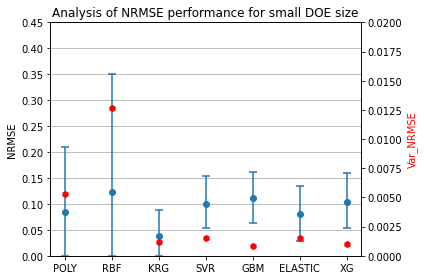

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#surrogate_type= value_for that_model_at(function3, function5,function9,function12,functio14,function17)

poly_s=np.array([1.2060469401975198e-15, 0.13953512602808038 ,0.016370312337719163, 0.20902547875007277,
                     0.0460940536461971, 0.09890925423428261]);
rbf_s=np.array([0.0002669429044090837, 0.12119050186409772, 0.35009665130800327, 0.14169641203247907, 
                    0.032735466196327154, 0.09618372364224839]);
krg_s=np.array([0.00015040029750187467,0.03878679082209754, 0.001758698999037996, 0.08829381740364005,
                    0.02480300970649758, 0.07587437808971097 ]);
svr_s=np.array([0.059809763058380434, 0.0830044295218673, 0.05451560942723366, 0.10642458673280465,
                    0.14530535283202536, 0.1541506119103728 ]);
gbm_s=np.array([0.16102290709563957, 0.12416763269307356, 0.06363618135305783, 0.11575427890413977, 
                    0.09499358780307147, 0.11115277770166396]);
elastic_s=np.array([0.09220004862738955, 0.13405474557911812, 0.030382617410545203, 0.11089487821993042,
                        0.028757013958949494, 0.0852584748985765]);
xg_s=np.array([0.16042699377766315,0.0999333345289453, 0.05329763438403425, 0.11680857721425535, 
                   0.08869359980879514,0.10894875669457775]);


# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);



fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)

ax2 = ax.twinx()
ax2.errorbar(x_pos,v,fmt='r.',marker='h')
ax2.set_ylim(0,0.02)
plt.ylabel('Var_NRMSE', color='r')


# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()



                    

Conclusion-
According to Kianifar et al.(2019), if the variance of 
NRMSE is less than 0.05 (i.e. less than 5% of the average response value), the modelling methodology can be accepted as robust. 
1. Kriging outperforms other modelling strategies in terms of robustness—judged based on the average and range of NRMSE across the fitted models and the variance of NRMSE.

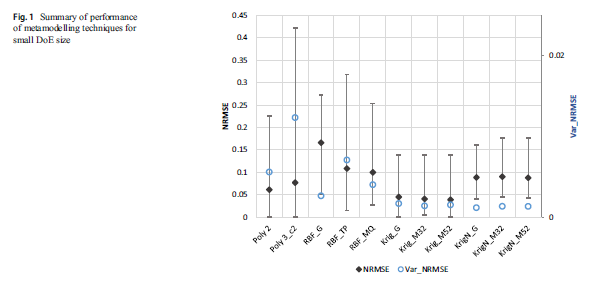

# SMALL DOE (LOW LINEARITY FUNCTIONS-3,9,14)

---


THESE ARE SMALL (3),MEDIUM (9),HIGH SCALE (14)

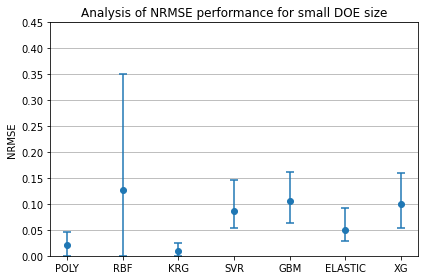

In [ ]:

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function3, function9,functio14)

poly_s=np.array([1.2060469401975198e-15, 0.016370312337719163, 0.0460940536461971]);
rbf_s=np.array([0.0002669429044090837, 0.35009665130800327, 
                    0.032735466196327154]);
krg_s=np.array([0.00015040029750187467,0.001758698999037996, 
                    0.02480300970649758 ]);
svr_s=np.array([0.059809763058380434,  0.05451560942723366, 
                    0.14530535283202536 ]);
gbm_s=np.array([0.16102290709563957,  0.06363618135305783, 
                    0.09499358780307147]);
elastic_s=np.array([0.09220004862738955,  0.030382617410545203, 
                        0.028757013958949494]);
xg_s=np.array([0.16042699377766315, 0.05329763438403425, 
                   0.08869359980879514]);


# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)



# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

                    

Conclusion- 

1.  Both Kriging and Polymial are performing good in terms of mean and variance in the above case. 
2. RBF does not perform well.





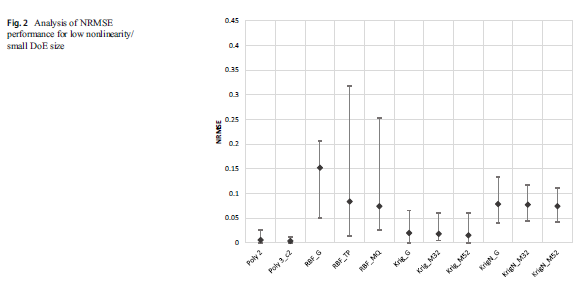

#SMALL DOE(HIGH LINEARITY FUNCTIONS- 5,12,17)

---


THESE ARE SMALL(5), MEDIUM(12), LARGE (17)

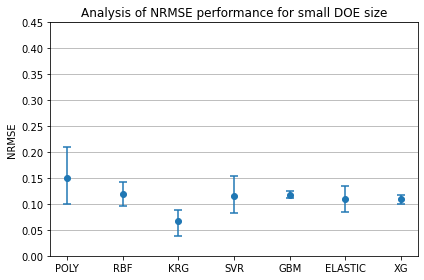

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function5,function12,function17)

poly_s=np.array([0.13953512602808038 , 0.20902547875007277,
                      0.09890925423428261]);
rbf_s=np.array([ 0.12119050186409772,  0.14169641203247907, 
                     0.09618372364224839]);
krg_s=np.array([0.03878679082209754, 0.08829381740364005,
                     0.07587437808971097 ]);
svr_s=np.array([ 0.0830044295218673,  0.10642458673280465,
                   0.1541506119103728 ]);
gbm_s=np.array([ 0.12416763269307356,  0.11575427890413977, 
                     0.11115277770166396]);
elastic_s=np.array([ 0.13405474557911812, 0.11089487821993042,
                         0.0852584748985765]);
xg_s=np.array([0.0999333345289453, 0.11680857721425535, 
                   0.10894875669457775]);


# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

                    

Conclusion- 


1.   Kriging performs best.
2.  GBM and XG Boost metamodel give very small range but the NRMSE mean value is larger than kriging.
3.  Polynomial gives high mean value thus shows that model is not flexible enough for highly non-linear functions here.

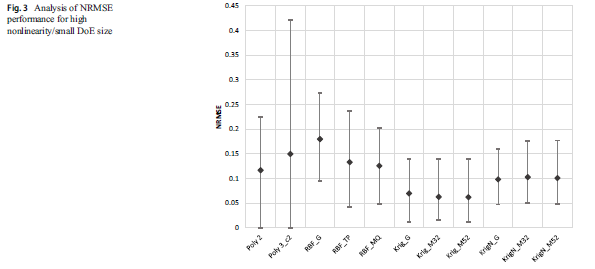

#SMALL DOE (LOW SCALE FUNCTIONS- 3,5)

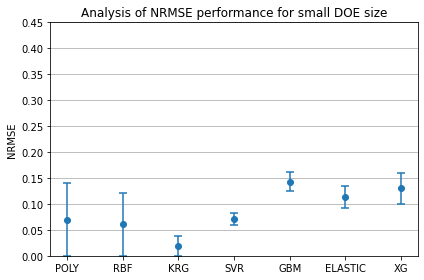

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function3, function5)

poly_s=np.array([1.2060469401975198e-15, 0.13953512602808038 ]);
rbf_s=np.array([0.0002669429044090837, 0.12119050186409772]);
krg_s=np.array([0.00015040029750187467,0.03878679082209754 ]);
svr_s=np.array([0.059809763058380434, 0.0830044295218673 ]);
gbm_s=np.array([0.16102290709563957, 0.12416763269307356]);
elastic_s=np.array([0.09220004862738955, 0.13405474557911812]);
xg_s=np.array([0.16042699377766315,0.0999333345289453]);

# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];
# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

                    

Conclusion
1. Kriging outperforms all models
2. SVR, GBM, ELASTIC models gives small range but higher mean values of NRMSE than kriging

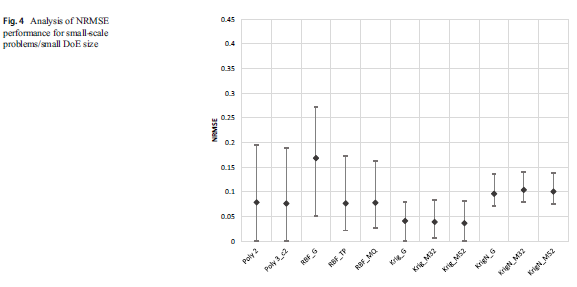

#SMALL DOE (MEDIUM SCALE FUNCTIONS-9,12)

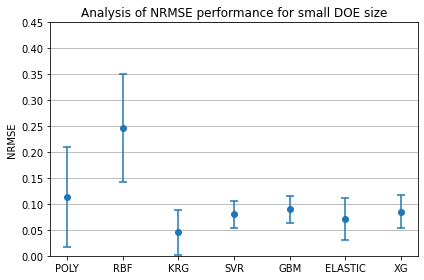

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function9,function12)

poly_s=np.array([0.016370312337719163, 0.20902547875007277]);
rbf_s=np.array([ 0.35009665130800327, 0.14169641203247907]);
krg_s=np.array([0.001758698999037996, 0.08829381740364005 ]);
svr_s=np.array([0.05451560942723366, 0.10642458673280465]);
gbm_s=np.array([ 0.06363618135305783, 0.11575427890413977]);
elastic_s=np.array([ 0.030382617410545203, 0.11089487821993042]);
xg_s=np.array([ 0.05329763438403425, 0.11680857721425535]);

# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

Conclusion- Kriging gives lowest NRMSE mean but the range is higher than SVR, GBM, ELASTIC, XG BOOST 

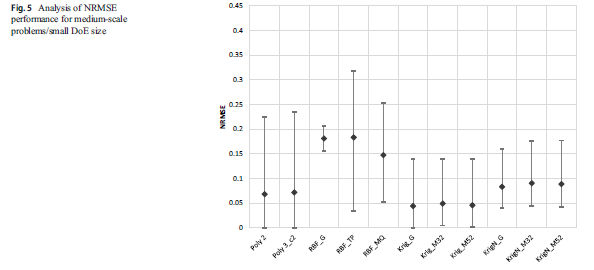

#SMALL DOE(LARGE SCALE FUNCTIONS-14,17)

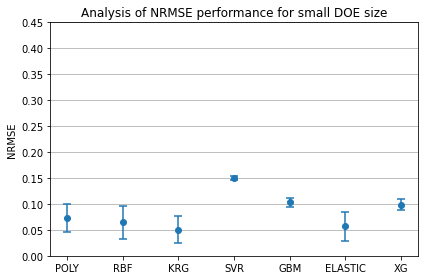

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
%matplotlib inline
#surrogate_type= value_for that_model_at(functio14,function17)

poly_s=np.array([0.0460940536461971, 0.09890925423428261]);
rbf_s=np.array([0.032735466196327154, 0.09618372364224839]);
krg_s=np.array([0.02480300970649758, 0.07587437808971097 ]);
svr_s=np.array([0.14530535283202536, 0.1541506119103728 ]);
gbm_s=np.array([0.09499358780307147, 0.11115277770166396]);
elastic_s=np.array([.028757013958949494, 0.0852584748985765]);
xg_s=np.array([0.08869359980879514,0.10894875669457775]);

# Calculate the average
poly_mean_s= np.mean(poly_s);
rbf_mean_s = np.mean(rbf_s);
krg_mean_s= np.mean(krg_s);
svr_mean_s=np.mean(svr_s);
gbm_mean_s=np.mean(gbm_s);
elastic_mean_s=np.mean(elastic_s);
xg_mean_s=np.mean(xg_s);

# Calculate the variance
poly_v_s= np.var(poly_s);
rbf_v_s = np.var(rbf_s);
krg_v_s= np.var(krg_s);
svr_v_s=np.var(svr_s);
gbm_v_s=np.var(gbm_s);
elastic_v_s=np.var(elastic_s);
xg_v_s=np.var(xg_s);

fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_s, rbf_mean_s,krg_mean_s,svr_mean_s,gbm_mean_s,elastic_mean_s,xg_mean_s]
v = [poly_v_s, rbf_v_s,krg_v_s,svr_v_s,gbm_v_s,elastic_v_s,xg_v_s];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_s-np.min(poly_s)), (rbf_mean_s-np.min(rbf_s)),(krg_mean_s-np.min(krg_s)),
                (svr_mean_s-np.min(svr_s)),(gbm_mean_s-np.min(gbm_s)),(elastic_mean_s-np.min(elastic_s)),(xg_mean_s-np.min(xg_s))]);
max= np.array([(np.max(poly_s)-poly_mean_s),(np.max(rbf_s)-rbf_mean_s),(np.max(krg_s)-krg_mean_s),
                (np.max(svr_s)-svr_mean_s),(np.max(gbm_s)-gbm_mean_s),(np.max(elastic_s)-elastic_mean_s),(np.max(xg_s)-xg_mean_s)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for small DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()
                    

Conclusion-
Kriging has lowest mean NRMSE, Elastic Net also performing well. 

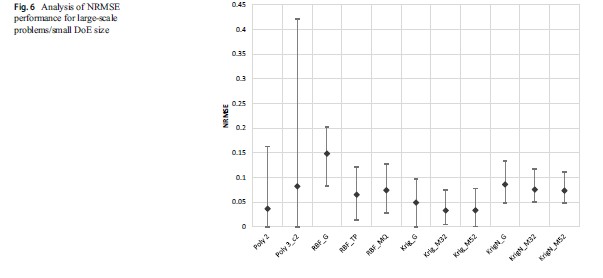

#LARGE DOE-ALL FUNCTIONS

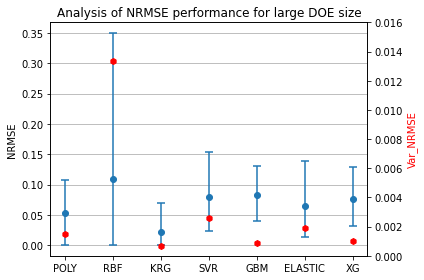

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#surrogate_type= value_for that_model_at(function3, function5,function9,function12,functio14,function17)

poly_l=np.array([1.8499087302181918e-15, 0.10753983745409237, 0.05329763438403425, 0.0912883405320599,
                     0.011035876721114087,0.05580997004429975]);
rbf_l=np.array([4.878733288989962e-05, 0.10900979485588753, 0.3500099807870392, 0.08863455768176592,
                    0.011083723009611237, 0.09206775285456494]);
krg_l=np.array([9.088566747516961e-07, 0.008069620350955022, 0.00027126537743330626,0.04629015736579685,
                    0.011014127977512316,0.0698234985925731]);
svr_l=np.array([0.022778120952293097, 0.05549511274074191, 0.03523601723374373, 0.06726387953315445, 
                    0.1439270940329886, 0.15417746202358512]);
gbm_l=np.array([0.13036237908172274, 0.06583033134498405, 0.03927589979613213, 0.10150571184087015,
                    0.06767561712666145,0.09081876914243416]);
elastic_l=np.array([0.05989444807452776, 0.13916614944096403, 0.02333164092488561, 0.10066589400602985,
                        0.012805659948478557, 0.05494200108931481]);
xg_l=np.array([0.12858694648824096, 0.058915667657323575, 0.03165347526877845,0.10237839444418462, 
                   0.05729742123825094, 0.08139346962910593]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference

min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

ax2 = ax.twinx()
ax2.errorbar(x_pos,v,fmt='r.',marker='h')
ax2.set_ylim(0,0.016)
plt.ylabel('Var_NRMSE', color='r')

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()                  

Conclusion-
1. The variance values of all metamodel has reduced on comparing with variances obtained with smaller doe training set.
2. Here also Kriging is performing better than all models in terms of range and variance ie Kriging is most robust for both small and large doe sizes for functions of different scales and linearity.
3. RBF gives very high range. Also the variance (scale right side) has not much improved on changind the doe traing set.
4. Polynomial metamodel also giving reasonable value of variance (around 0.05) 

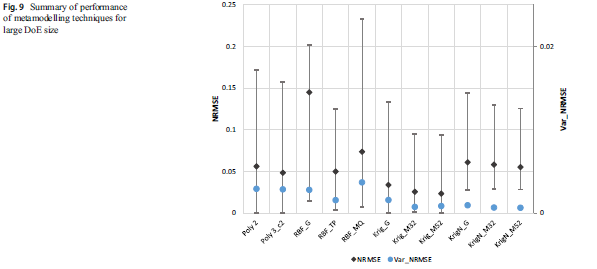

It can be observed that on comparing with small sample DoE, the robustness of all modelling strategies is improved noticeably with the large DoE sizes (as shown by both NRMSE and variance of NRMSE values).
As kriging is performing best here also, this implies kriging is the best metamodel for small and large doe training set.

#LARGE DOE (LOW LINEARITY FUNCTIONS-3,9,14)

---
THESE ARE SMALL(3), MEDIUM(9), LARGE (14)



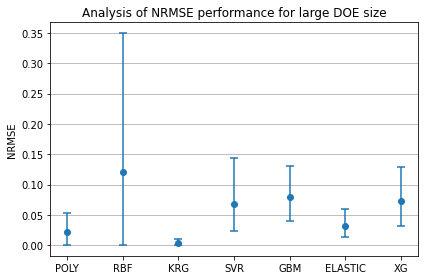

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#surrogate_type= value_for that_model_at(function3,function9,functio14)

poly_l=np.array([1.8499087302181918e-15,  0.05329763438403425,
                     0.011035876721114087]);
rbf_l=np.array([4.878733288989962e-05, 0.3500099807870392, 
                    0.011083723009611237]);
krg_l=np.array([9.088566747516961e-07,  0.00027126537743330626,
                    0.011014127977512316]);
svr_l=np.array([0.022778120952293097,  0.03523601723374373, 
                    0.1439270940329886]);
gbm_l=np.array([0.13036237908172274, 0.03927589979613213, 
                    0.06767561712666145]);
elastic_l=np.array([0.05989444807452776, 0.02333164092488561, 
                        0.012805659948478557]);
xg_l=np.array([0.12858694648824096,  0.03165347526877845,
                   0.05729742123825094]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference


min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)

ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show() 

Conclusion
1. Polynomial, Kriging, Elastic Net perform well, with Kriging giving best results.
2. RBF gives largest range.

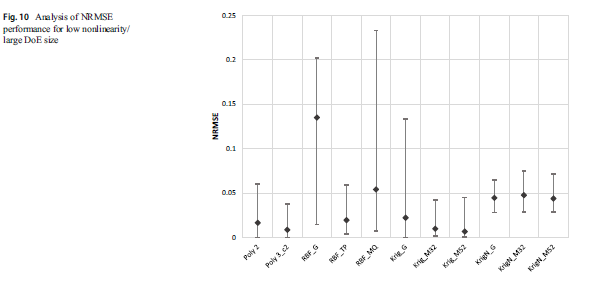

#LARGE DOE(HIGH LINEARITY FUNCTIONS-5,12,17)

---
THESE ARE SMALL(5), MEDIUM(12), LARGE (17) 


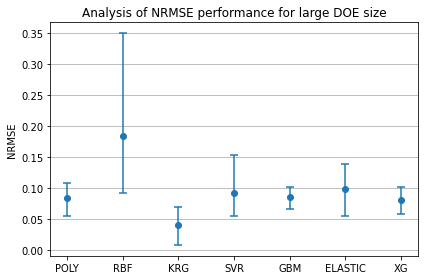

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function5,function12,function17)

poly_l=np.array([ 0.10753983745409237,  0.0912883405320599,0.05580997004429975]);
rbf_l=np.array([0.10900979485588753, 0.3500099807870392, 0.09206775285456494]);
krg_l=np.array([ 0.008069620350955022, 0.04629015736579685,0.0698234985925731]);
svr_l=np.array([ 0.05549511274074191,  0.06726387953315445, 0.15417746202358512]);
gbm_l=np.array([0.06583033134498405,  0.10150571184087015,0.09081876914243416]);
elastic_l=np.array([ 0.13916614944096403,  0.10066589400602985, 0.05494200108931481]);
xg_l=np.array([ 0.058915667657323575, 0.10237839444418462, 0.08139346962910593]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference


min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)

ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()          

Conclusion
1. Kriging performs best for highly non linear functions.
2. Polynomial, SVR, GBM,ELASTIC Net,XG Boost give similar performances with lowest range for GBM.

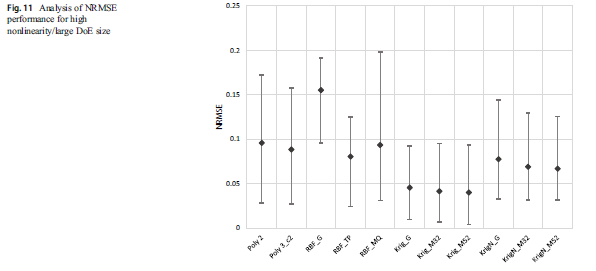

#LARGE DOE(SMALL SCALE FUNCTIONS-3,5)

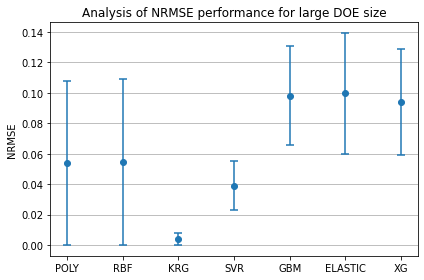

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function3, function5)

poly_l=np.array([1.8499087302181918e-15, 0.10753983745409237]);
rbf_l=np.array([4.878733288989962e-05, 0.10900979485588753]);
krg_l=np.array([9.088566747516961e-07, 0.0080696203509550221]);
svr_l=np.array([0.022778120952293097, 0.05549511274074191]);
gbm_l=np.array([0.13036237908172274, 0.06583033134498405]);
elastic_l=np.array([0.05989444807452776, 0.13916614944096403]);
xg_l=np.array([0.12858694648824096, 0.058915667657323575]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the standard deviation
poly_std_l= np.std(poly_l);
rbf_std_l = np.std(rbf_l);
krg_std_l= np.std(krg_l);
svr_std_l=np.std(svr_l);
gbm_std_l=np.std(gbm_l);
elastic_std_l=np.std(elastic_l);
xg_std_l=np.std(xg_l);


# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference


min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)

ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show() 

Conclusion
1. Kriging outperforms all other model with lowest mean and range.

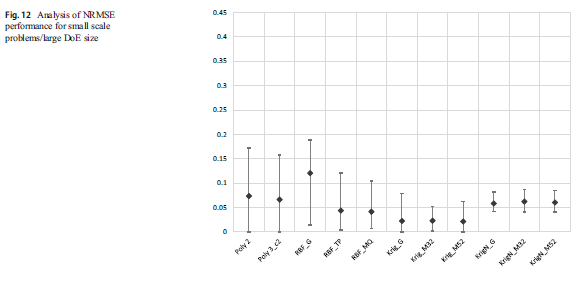

#LARGE DOE(MEDIUM SCALE FUNCTIONS-9,12)

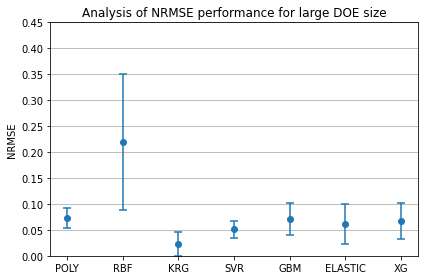

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(function9,function12)

poly_l=np.array([0.05329763438403425, 0.0912883405320599]);
rbf_l=np.array([ 0.3500099807870392, 0.08863455768176592]);
krg_l=np.array([ 0.00027126537743330626,0.04629015736579685]);
svr_l=np.array([ 0.03523601723374373, 0.06726387953315445]);
gbm_l=np.array([0.03927589979613213, 0.10150571184087015]);
elastic_l=np.array([ 0.02333164092488561, 0.10066589400602985]);
xg_l=np.array([0.03165347526877845,0.10237839444418462]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);


# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference


min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.45)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show() 

Conclusion
1. All models except RBF gives good results.
2. Kriging comes out as best model in this case also.

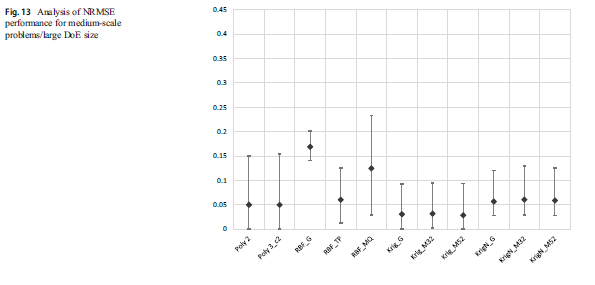

#LARGE DOE(LARGE SCALE FUNCTIONS-14,17)

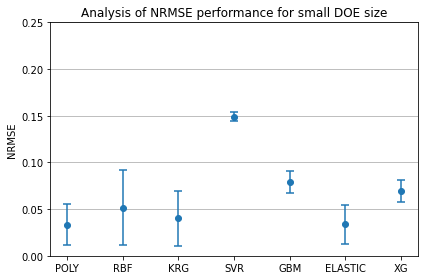

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#surrogate_type= value_for that_model_at(functio14,function17)

poly_l=np.array([0.011035876721114087,0.05580997004429975]);
rbf_l=np.array([ 0.011083723009611237, 0.09206775285456494]);
krg_l=np.array([0.011014127977512316,0.0698234985925731]);
svr_l=np.array([0.1439270940329886, 0.15417746202358512]);
gbm_l=np.array([0.06767561712666145,0.09081876914243416]);
elastic_l=np.array([0.012805659948478557, 0.05494200108931481]);
xg_l=np.array([ 0.05729742123825094, 0.08139346962910593]);

# Calculate the average
poly_mean_l= np.mean(poly_l);
rbf_mean_l = np.mean(rbf_l);
krg_mean_l= np.mean(krg_l);
svr_mean_l=np.mean(svr_l);
gbm_mean_l=np.mean(gbm_l);
elastic_mean_l=np.mean(elastic_l);
xg_mean_l=np.mean(xg_l);

# Calculate the variance
poly_v_l= np.var(poly_l);
rbf_v_l = np.var(rbf_l);
krg_v_l= np.var(krg_l);
svr_v_l=np.var(svr_l);
gbm_v_l=np.var(gbm_l);
elastic_v_l=np.var(elastic_l);
xg_v_l=np.var(xg_l);


fig, ax = plt.subplots()

# Define labels, positions, bar heights and error bar heights
labels = ['POLY', 'RBF', 'KRG','SVR','GBM','ELASTIC','XG'];
x_pos = np.arange(len(labels))
mean = [poly_mean_l, rbf_mean_l,krg_mean_l,svr_mean_l,gbm_mean_l,elastic_mean_l,xg_mean_l]
v = [poly_v_l, rbf_v_l,krg_v_l,svr_v_l,gbm_v_l,elastic_v_l,xg_v_l];

# Measuring the +ve and -ve limit for y_error_bar taking mean as the reference


min= np.array([(poly_mean_l-np.min(poly_l)), (rbf_mean_l-np.min(rbf_l)),(krg_mean_l-np.min(krg_l)),
                (svr_mean_l-np.min(svr_l)),(gbm_mean_l-np.min(gbm_l)),(elastic_mean_l-np.min(elastic_l)),(xg_mean_l-np.min(xg_l))]);
max= np.array([(np.max(poly_l)-poly_mean_l),(np.max(rbf_l)-rbf_mean_l),(np.max(krg_l)-krg_mean_l),
                (np.max(svr_l)-svr_mean_l),(np.max(gbm_l)-gbm_mean_l),(np.max(elastic_l)-elastic_mean_l),(np.max(xg_l)-xg_mean_l)]);
err=(min,max);

# Build the plot

ax.errorbar(x_pos,mean,yerr=err,fmt='o', elinewidth=1.5, capsize=4, capthick=1.5)
ax.set_ylim(0,0.25)
ax.set_ylabel('NRMSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Analysis of NRMSE performance for large DOE size')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show() 
                    

Conclusion
1. Polynomial, Elastic Net and Kriging performance is good Elastic doing slightly better.
2. RBF also has reasonable mean but has larger range.

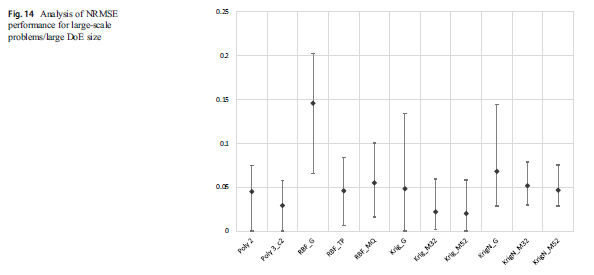

# Generating DoE small size

In [ ]:
!pip install smt
 #required libraries
import numpy as np
import math

def f5(x):
  A=[[3.0,10,30],[0.1,10,35],[3.0,10,30],[0.1,10,35]];
  a=[1.0, 1.2, 3.0, 3.2];
  P=[[0.3689,0.1170,0.2673], [0.4699, 0.4387, 0.7470], [0.1091, 0.8732, 0.5547],[0.0381, 0.5743,0.8828]];
  dim=3;
  s=0;
  for i in range(4):
    p=0;
    for j in range(dim):
      p=p+A[i][j]*(x[j]-P[i][j])*2;
    s=-(s+a[i]*(math.e)**p);
  return s


  #generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds, n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

bound=np.array([[0,1],[0,1],[0,1]]);
x,y =generate_data(bound,40,f5)
print (x)
print (y)

In [ ]:
 !pip install smt
 #required libraries
import numpy as np
import math

def f3(x):
  b=[8, 18, 44, 114];
  dim=4;
  s=0;
  for i in range(dim):
    inner=0;
    for j in range(dim):
      inner=inner+(x[j])**(i+1)
    s=s+(inner-b[i])**2;
    return s
    
#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds, n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

bound=np.array([[0,4],[0,4],[0,4],[0,4]]);
x,y =generate_data(bound,40,f3)

print (x)

print (y)


In [ ]:

!pip install smt
 #required libraries
import numpy as np
import math

# function 9
def f9(a):
  nd=40;
  f=[0]*nd;
  
  for i in range(nd):
    n=2*(math.pi)*a[2][i]*(a[3][i]-a[5][i]);
    den1=math.log(a[1][i]/a[0][i]);
    den2=1+(2*a[6][i]*a[2][i])/(math.log(a[1][i]/a[0][i])*a[0][i]**2*a[7][i])+a[2][i]/a[4][i];
    f[i]=n/(den1*den2);
  return f

 # rw= lb=0.05 ub= 0.15, r= lb=100; ub=50000,
# Tu= lb=63070; ub=115600, Hu= lb=990; ub=1110,
# Tl= ub=63.1; ub=116, Hl=lb=700; ub= 820,
# L= lb=1120; ub=1680 and Kw= lb=9855; ub=12045;   

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

bound=np.array([[0.05,0.15],[100,50000],[63070,115600],[990,1110],[63.1,116],[700,820],[1120,1680],[9855,12045]]);
x,y=generate_data(bound,40,f9);

print (x)
print (y)


In [ ]:
!pip install smt
 #required libraries
import numpy as np
import math

# function 12
u=0;
v=0;
def f12(x):
  nd=40;
  f=[0]*nd;
  for i in range(nd):
    u=0;
    v=0;
    for j in range(0,5):
      t=0;
      for k in range(0,j):
        t=t+x[k+4][i];
      u=u+x[j][i]*math.cos(t);
      v=v+x[j][i]*math.sin(t);
    f[i]=(u**2+v**2)**0.5;

  return f

  #generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y

bound=np.array([[0,1],[0,1],[0,1],[0,1],[0,math.pi],[0,math.pi],[0,math.pi],[0,math.pi]]);
x,y =generate_data(bound,40,f12)

print (x)
print (y)


In [ ]:
!pip install smt
 #required libraries
import numpy as np
import math

# function 14
def f14(xx):
  s=so=0;
  a=np.eye(16);
  a[0][3]=a[0][7]=a[0][5]=a[0][6]=1;
  a[1][2]=a[1][6]=a[1][9]=1;
  a[2][6]=a[2][8]=a[2][9]=a[2][13]=1;
  a[3][6]=a[3][10]=a[3][14]=1;
  a[4][5]=a[4][9]=a[4][11]=a[4][15]=1;
  a[12][13]=a[11][13]=a[11][13]=1;
  a[7][14]=a[10][12]=a[9][13]=a[8][15]=1;
  a[5][7]=a[8][15]=a[6][12]=a[5][14]=1;
  dim=16;
  #nd=40;
  #f=[0]*nd;
  for i in range(dim):
    for j in range(dim):
      s=s+a[i][j]*(xx[i]**2+xx[i]+1)*(xx[j]**2+xx[j]+1);
    so=so+s;
  return so


#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y
dim=16;
bound=np.array([[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5]]);
x,y =generate_data(bound,40,f14)

print (x)
print (y)


In [ ]:
!pip install smt
 #required libraries
import numpy as np
import math

# function 17
def f17(a):
  nd=40;
  dim=40;
  f=[0]*nd;
  dim=14;
  for i in range(nd):
    s=0;
    x1=a[1][i];
    for m in range(1,dim):
      s=s+m*(2*a[m][i]**2-a[m-1][i])**2;
    f[i]=(x1-1)**2+s;

  return f

#generate LHS DoE
from smt.sampling_methods import LHS
def generate_data(bounds,n_doe,testfunc):
  sampling=LHS(xlimits=bounds, criterion='m')
  data_x=sampling(n_doe)
  data_xt=np.transpose(data_x)
  data_y=testfunc(data_xt)
  return data_x ,data_y


bound=np.array([[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10],[-10,10]]);
x,y =generate_data(bound,40,f17)

print (x)
print (y)

# G1 METAMODELS

In [ ]:
# Polynomial response surface (PRS)
def prs_srgt(x,y,degree = 2):
  # degree is an integer that specifies the degree of the polynomial
  from sklearn.linear_model import LinearRegression as lr
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), lr())
  srgt = model.fit(x,y)
  return srgt

  # Kriging
def kriging_srgt(x,y, poly ='constant', corr='squar_exp', theta=[0.01]):
  from smt.surrogate_models import KRG
  model = KRG(poly = poly, corr = corr, theta0 = theta)
  model.set_training_values(x,y)
  model.train()

  return model

# Radial Basis Function (RBF)
# Only has one basis function - Gaussian
def rbf_srgt(x,y,sigma=200):
  from smt.surrogate_models import RBF
  model = RBF(d0 = sigma)
  model.set_training_values(x,y)
  model.train()

  return model


# Support Vector Regression (SVR)
def svr_srgt(x,y,kernel='rbf',C=100,degree=2,epsilon=0.02):
  from sklearn.svm import SVR
  from sklearn.preprocessing import StandardScaler
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(StandardScaler(), SVR(kernel=kernel,C=C,degree=degree,epsilon=epsilon))
  srgt = model.fit(x,y)
  return srgt


# XGBoost
def xgboost_srgt(x,y):
  from xgboost import XGBRegressor as xgbr
  model = xgbr()
  srgt = model.fit(x,y)

  return srgt

# Elastic Net
def elastic_net_srgt(x,y,degree = 2, l1_ratios = [0.1, 0.5, 0.9], alphas = (0.1,1.0,10.0)):
  # degree is an integer which specifies the degree of the polynomial model
  # l1_ratios is a list that specifies the extent of l1 vs l2 regularization
  # alphas is a nd array that specifies that different levels of l1 regularization
  from sklearn.linear_model import ElasticNetCV
  from sklearn.preprocessing import PolynomialFeatures
  from sklearn.pipeline import make_pipeline
  model = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas))
  srgt = model.fit(x,y)
  return srgt

  # GBM
def gbm_srgt(x,y,params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}):
  from sklearn.ensemble import GradientBoostingRegressor as gbmr
  model = gbmr(**params)
  srgt = model.fit(x,y)

  return srgt